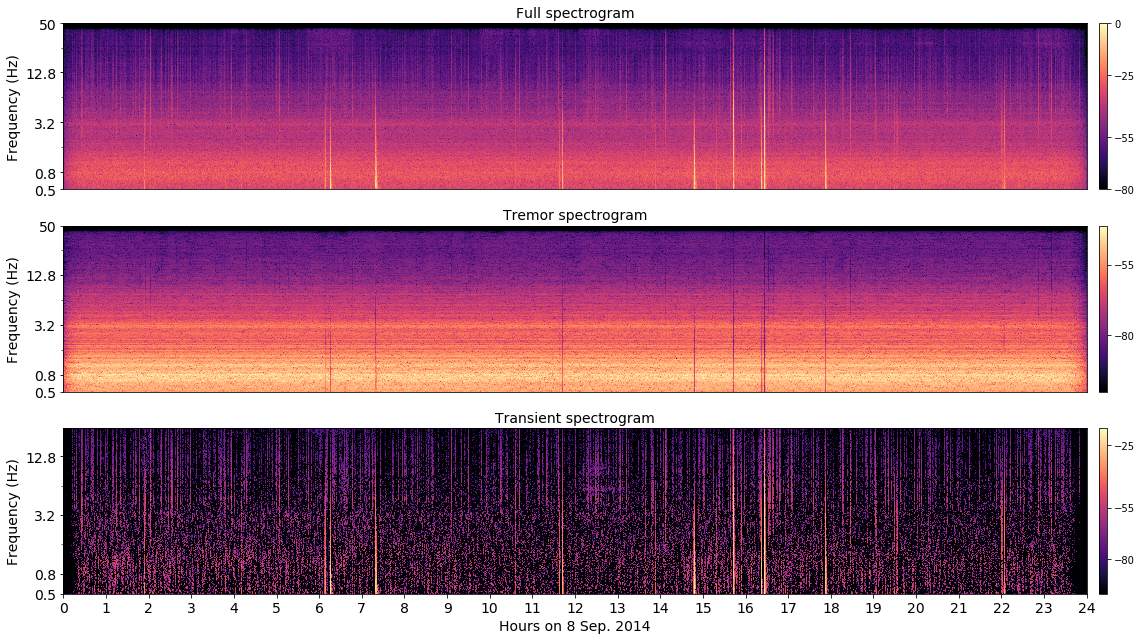

In [4]:
# New method for separating the seismic spectrogram into two spectrograms of harmonic and transient patterns
# The output are: 1- A figure of original signal spectrogram + tremor spectrogram + transients spectrogram. 2- mseed file of extracted tremor
# I recommend applying a highpass filter above the microseism frequency band before the separation process if you want to extract volcanic tremor.
# If you don't apply the highpass filter, the extracted tremor signal is highly affected by the microseism tremor signal
# because it has the dominant energy in the tremor spectrogram

import obspy
import librosa
import numpy as np
import librosa.display
import datetime
import matplotlib.pyplot as plt

file= obspy.read ('2014251restitute-highpassfilter0.5.mseed')
x=file[0].data
y=x.astype(float)
    
    ### Separation with high resolution in frequency domain for tremor extraction
    # Choose a large n_fft for high resolution in frequency domain
    
k=2
sr=16000
hop_length=2048
win_length=8192
n_fft= 8192

# Compute the spectrogram amplitude and phase
S_full, phase = librosa.magphase(librosa.stft(y, n_fft= n_fft, hop_length=hop_length, win_length=win_length))
    
# We'll compare frames using cosine similarity, and aggregate similar frames by taking their (per-frequency) median value.
S_filter = librosa.decompose.nn_filter(S_full,aggregate=np.median,metric='cosine',width=2)
        
# The output of the filter shouldn't be greater than the input
S_filter = np.minimum(S_full, S_filter)
margin_i, margin_v = 1, 1
power = 2

# Once we have the masks, simply multiply them with the input spectrogram to separate the components
mask_i = librosa.util.softmask(S_filter,margin_i * (S_full - S_filter),power=power)
mask_v = librosa.util.softmask(S_full - S_filter,margin_v * S_filter,power=power)

S_foreground = mask_v * S_full
S_background = mask_i * S_full

# Decompose spectrograms into harmonic and percussive components
H1, P1 = librosa.decompose.hpss(S_background)
H2, P2 = librosa.decompose.hpss(S_foreground)

# Plot Spectrograms
fig= plt.figure(figsize=(18, 9))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.power_to_db(S_full, ref=np.max),y_axis='log', sr=sr)
plt.title('Full spectrogram', fontsize= 14)
plt.ylabel('Frequency (Hz)', fontsize= 14)
freq =[80,128, 512, 2048, 8000]
labelsy = [0.5, 0.8, 3.2, 12.8, 50]
plt.yticks (freq, labelsy, fontsize= 14)
plt.colorbar(pad= 0.01, ticks=[0, -25, -55, -80])
plt.ylim(80,8000)

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.power_to_db(np.abs(H1)), sr=sr,y_axis='log')
plt.ylabel('Frequency (Hz)', fontsize= 14)
plt.title('Tremor spectrogram', fontsize= 14)
freq =[80,128, 512, 2048, 8000]
labelsy = [0.5, 0.8, 3.2, 12.8, 50]
plt.yticks (freq, labelsy, fontsize= 14)
plt.colorbar(pad= 0.01, ticks=[0, -25, -55, -80])
plt.ylim(80,8000)
    
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.power_to_db(np.abs(P2)), sr=sr, y_axis='log')
plt.title('Transient spectrogram', fontsize= 14)
plt.ylabel('Frequency (Hz)', fontsize= 14)
freq =[80,128, 512, 2048, 8000]
labelsy = [0.5, 0.8, 3.2, 12.8, 50]
plt.yticks (freq, labelsy, fontsize= 14)
plt.colorbar(pad= 0.01, ticks=[0, -25, -55, -80])
#plt.ylim(0, 5600)
labelsx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
plt.xticks(np.arange(0,4220, 175.79), labelsx, fontsize= 14)
plt.xlabel('Hours on 8 Sep. 2014', fontsize= 14)
plt.ylim(80,4000)
plt.tight_layout()
fig.savefig ('2014251-harmonic percussive separation.png', dpi=150)


In [6]:
# Phase modifying algorithm. We use this modified phase in order to reconstruct the tremor signal from the tremor spectrogram
# the output is the reconstructed tremor signal with the respective phase information

# find the index of lower limit and upper limit of the dominant frequency energy in the tremor spectrogram for each time frames
import numpy as np

lower_limit_index = []
upper_limit_index = []

for n in range (0,4219):  # Number of H1 time frames
    H2=H1 [:,n]
    squared_integral = np.cumsum(H2*H2)
    squared_integral = squared_integral/squared_integral[-1]
    for i in range (len (squared_integral)):
        if squared_integral[i]>= 0.05:
            break
    #print ("Index of integral exceeding 0.05: ",i)
    lower_limit_index.append(i)
    
    for i in range (len (squared_integral)):
        if squared_integral[i]>= 0.95:
            break
    #print("Last Index of integral before exceeding 0.95: ",i-1)
    upper_limit_index.append(i-1)

l =lower_limit_index
u =upper_limit_index

for n in range (len(l)):
    ll=int(l[n])
    ul=int(u[n])
    phase[0:ll,n]=0
    phase[ul:4097,n]=0
    
# Multiply the tremor spectrogram with the modified phase matrix
T=H1*phase
L = y.shape[0]
# istft of harmonic pattern
RT = librosa.istft(T, hop_length=hop_length, win_length=win_length, window='hann', length=L)  # istft of harmonic pattern

# extract reconstructed tremor as mseed file
import obspy
from obspy import UTCDateTime, read, Trace, Stream
stats = file[0].stats
stats.location= 'H1'
st = Stream([Trace(data=RT, header=stats)])
st.write( 'Extracted tremor-2014-09-08.mseed', format='MSEED', encoding=4, reclen=4096)